### Load Instruction Data from URL (with Local Caching)

This code defines a utility function `download_and_load_file` that downloads a JSON dataset from a given URL if it doesn't already exist locally, and loads it for use.

- Uses Python’s `urllib` with a disabled SSL verification context (⚠️ not secure for production).
- If the file is not present, it downloads and writes the content to disk.
- If the file already exists, it reads it directly.
- Parses the JSON content and returns it.
- Finally, it prints the number of instruction entries loaded from the dataset.

The dataset used here is `instruction-data.json` hosted on GitHub, which contains instruction-response pairs for training or evaluating instruction-tuned language models.


In [ ]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


### Format Instruction-Input Prompt

The `format_input` function prepares an input prompt from an instruction-entry dictionary. It formats the text in a structured template for instruction-tuned models.

- Adds a task description line: _"Below is an instruction that describes a task..."_
- Appends the `instruction` field under a `### Instruction:` heading.
- If an `input` field is present (non-empty), it appends it under a `### Input:` heading.
- Returns the complete prompt string to be fed into the language model.

This formatting helps the model clearly distinguish between the instruction and optional input, following conventions similar to datasets like FLAN or Alpaca.


In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

### Preview a Formatted Instruction-Response Pair

This block demonstrates how to use the `format_input` function to construct a complete prompt for a specific instruction example (in this case, index 50 of the dataset).

- `model_input` contains the instruction and input formatted using the defined prompt template.
- `desired_response` appends the expected output, prefixed with `### Response:`.

The output helps visualize how the model is expected to read and respond to instruction-following prompts. This is especially useful for debugging prompt formatting or for sanity checks before training/inference.


In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


### Split the Dataset into Train, Validation, and Test Sets

This code splits the instruction dataset into three parts:

- **85%** of the data is used for training.
- **10%** is allocated for testing (to evaluate generalization after training).
- **5%** is reserved for validation (used during training for tuning and early stopping).

The splits are created using slicing:
- `train_data` contains the first 85% of the dataset.
- `test_data` follows next with 10%.
- `val_data` contains the remaining 5%.

This ensures no overlap and maintains reproducibility if the dataset order is fixed.

✅ Example Output:
- Training set length: 935  
- Validation set length: 55  
- Test set length: 110


In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


### Create a Custom PyTorch Dataset for Instruction Tuning

This class `InstructionDataset` is a custom `torch.utils.data.Dataset` designed for instruction tuning. It takes a list of instruction-response pairs and a tokenizer, and performs the following:

- **Tokenizes each example**: It formats the input using `format_input(entry)` and appends the expected output as
`### Response:...`
- **Encodes the full prompt** using the tokenizer and stores token IDs in `self.encoded_texts`.
- Implements `__getitem__` and `__len__` to support PyTorch `DataLoader`.

This dataset prepares each sample as a single sequence for language modeling or fine-tuning a decoder-only transformer like GPT-2.


In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

### Load GPT-2 Tokenizer and Encode Special Token

This code initializes the GPT-2 tokenizer using `tiktoken`, a fast tokenizer library by OpenAI. It then encodes the special token `<|endoftext|>`, which GPT-2 uses to indicate the end of a text sequence.

- The token ID for `<|endoftext|>` is `50256`.
- `allowed_special={"<|endoftext|>"}` ensures the tokenizer doesn't throw an error when encoding this special token.

This step is essential when preparing prompts or handling model outputs that rely on special tokens for stopping criteria.


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


### Custom Collate Function for Batching Instruction Data

This function, `custom_collate_draft_1`, prepares batches of tokenized input sequences for training or inference. It performs the following:

- **Adds an `<|endoftext|>` token** (ID: 50256) to the end of each sequence.
- **Pads all sequences** in the batch to the same length, ensuring uniform shape.
- The `batch_max_length` is calculated as the length of the longest sequence plus 1 (to accommodate the extra `<|endoftext|>` token).
- **Padding tokens are removed at the end of each sequence** (`padded[:-1]`) to keep the input consistent with autoregressive modeling requirements.

The final result is a `torch.Tensor` containing padded sequences, all of the same length and transferred to the target device (`cpu` or `cuda`).


In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


---
### Custom Collate Function with Input-Target Pairing (for Language Modeling)

The function `custom_collate_draft_2` prepares batches of tokenized sequences for **causal language modeling**, where:

- **Inputs**: All tokens except the last.
- **Targets**: All tokens except the first (i.e., shifted by 1 position).

#### 🔧 Key Steps:
- Appends the `<|endoftext|>` token (`50256`) to each sequence.
- Pads all sequences to the length of the longest (plus one).
- For each sequence:
  - `inputs`: All tokens except the final one (`[:-1]`)
  - `targets`: All tokens except the first (`[1:]`)
- Converts both lists into PyTorch tensors and moves them to the specified device (`cpu` or `cuda`).




In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


---
### `custom_collate_fn` — Advanced Collate Function for Instruction Tuning

This function prepares batched inputs and targets for causal language modeling, with added support for:

- **End-of-sequence token (`<|endoftext|>`)**
- **Padding with attention masking**
- **Target masking using `ignore_index`**
- **Optional sequence truncation**

#### 🧠 Key Features:
- Adds `<|endoftext|>` token (`50256`) to every sample.
- Pads sequences to match the longest sample in the batch.
- Targets are created by shifting inputs one position to the right.
- All **padding tokens after the first** are masked in the targets by replacing them with `ignore_index` (default `-100`) — ensuring they don't contribute to the loss.
- Optionally truncates inputs and targets to a fixed `allowed_max_length`.



In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


### Customizing the Collate Function with `functools.partial`

We use `functools.partial` to create a **preconfigured version** of the `custom_collate_fn`, where specific arguments like the `device` and `allowed_max_length` are fixed in advance.



In [ ]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

### Preparing DataLoaders for Training, Validation, and Testing

We initialize PyTorch `DataLoader` instances for the instruction-tuning dataset. Each split (train, val, test) uses the `InstructionDataset` class and the customized `collate_fn`.

#### Common Settings
- `batch_size`: Set to 8
- `num_workers`: Set to 0 for simplicity (no parallel data loading)
- `collate_fn`: Uses our `customized_collate_fn` with padding, truncation, and device assignment
- `drop_last`:
  - `True` for training to ensure all batches are uniform
  - `False` for validation and testing to preserve all data

#### DataLoader Behavior
- `shuffle=True` for training to improve generalization
- `shuffle=False` for validation and test to preserve order and reproducibility

This setup ensures that data is efficiently batched and ready for model consumption during each training phase.


In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

### GPT-2 Model Configuration (124M)

We define the configuration for a GPT-2 model with 124 million parameters. This dictionary sets the architectural and training-specific hyperparameters:

- **`vocab_size`**: 50257 — Size of the tokenizer's vocabulary (GPT-2 default).
- **`context_length`**: 256 — Maximum sequence length the model can handle.
- **`emb_dim`**: 768 — Dimension of both token embeddings and hidden representations.
- **`n_heads`**: 12 — Number of self-attention heads in each transformer block.
- **`n_layers`**: 12 — Total number of stacked transformer layers.
- **`dropout`**: 0.1 — Dropout probability for regularization during training.
- **`qkv_bias`**: `False` — Disables bias terms in the query, key, and value projections.

This configuration matches the architecture of the original GPT2-Small model (~124M parameters).


In [ ]:
import torch
import torch.nn as nn

In [ ]:
# Model configuration dictionary (124M parameter version)
GPT_CONFIG_124m={
    'vocab_size':50257,        # Size of the vocabulary; used in the embedding layer
    'context_length':256,     # Maximum number of tokens the model can consider at once (sequence length)
    'emb_dim':768,             # Dimensionality of the token embeddings and hidden states
    'n_heads':12,              # Number of attention heads in the multi-head attention mechanism
    'n_layers':12,             # Number of transformer blocks/layers in the model
    'dropout':0.1,             # Dropout rate used during training to prevent overfitting
    'qkv_bias':False           # Whether to use bias terms in the query, key, and value projection layers
}

### Multi-Head Attention with Causal Masking (Self-Attention)

This `MultiHeadAttention` module implements scaled dot-product self-attention, split across multiple heads. It includes **causal masking**, which prevents attention from accessing future tokens — essential for autoregressive transformers like GPT.

#### Key Components:
- **`d_in` / `d_out`**: Input and output dimensionality of the embeddings.
- **`num_heads`**: Number of parallel attention heads.
- **`head_dim`**: Computed as `d_out // num_heads`, this determines the dimensionality each head operates on.
- **`W_query`, `W_key`, `W_value`**: Linear layers used to compute the Q, K, V matrices.
- **`out_proj`**: Linear layer used to recombine the output of all attention heads.
- **Causal Masking**: Implemented using a precomputed upper-triangular matrix to ensure that each position can only attend to past and current tokens.

#### Forward Pass Steps:
1. Project the input `x` into Q, K, V matrices using linear layers.
2. Reshape to separate the attention heads and transpose for correct dimensions.
3. Compute attention scores using scaled dot product: `Q × Kᵀ / sqrt(head_dim)`.
4. Apply the **causal mask** to prevent future token access.
5. Use softmax to convert scores into attention weights.
6. Apply dropout and compute the final output as weighted sum over V.
7. Concatenate heads and project through `out_proj` to match `d_out`.

This module enables the model to focus on different parts of the input sequence simultaneously across different attention heads.


In [ ]:
#Implementing scaled dot-product attention with masking
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    # Just making sure the output size works with how many heads we want
    # Ensure the output dimension is divisible by the number of heads
    super().__init__()
    assert (d_out%num_heads==0),'d_out must be divisible by num_heads'

    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads              # Each head gets a slice of the total embedding

    # Linear layers to get Q, K, V
    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.out_proj=nn.Linear(d_out,d_out)        # this layer use to combine head outputs
    self.dropout=nn.Dropout(dropout)            # Dropout layer to prevent overfitting
    # Causal mask to prevent attention to future tokens
    self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_tokens,d_in=x.shape                  # b: batch size, num_tokens: sequence length
    # Linear projections
    queries=self.W_query(x)
    keys=self.W_key(x)                         # Shape: (b, num_tokens, d_out)
    values=self.W_value(x)

    # Break each into multiple heads for parallel attention
    #implicitly split the matrix by adding a `num_heads` dimension
    # Unroll last dim: (b, num_tokens, d_out) to (b, num_tokens, num_heads, head_dim)
    keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values=values.view(b,num_tokens,self.num_heads,self.head_dim) # Changed self.head to self.head_dim

    #transpose: (b,num_tokens,num_heads,head_dim) to (b,num_heads,num_tokens,head_dim)
    keys=keys.transpose(1,2)
    queries=queries.transpose(1,2)
    values=values.transpose(1,2)

    #Dot prod of each head
    # Compute scaled dot-product attention(self-attention) with a causal mask
    attn_scores=queries @ keys.transpose(2,3)       # Shape: (b, heads, seq_len, seq_len)

    # Original mask truncated to the number of tokens and converted to boolean
    #####mask_bool=self.mask.bool()[:num_tokens,:num_tokens]
    mask_bool = self.mask[:num_tokens, :num_tokens].bool().to(x.device)
    # Use the mask to fill attention scores
    attn_scores.masked_fill_(mask_bool,-torch.inf)
    ######attn_scores.masked_fill_(mask_bool, -1e9)

    attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
    attn_weights=self.dropout(attn_weights)

    # Shape: (b, num_tokens, num_heads, head_dim)
    context_vec=(attn_weights @values).transpose(1,2)

    # Combine heads, where self.d_out = self.num_heads * self.head_dim
    context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out) # contiguous is used for reshape matrices in same block of memory
    context_vec=self.out_proj(context_vec)
    return context_vec

### Custom Layer Normalization with Learnable Parameters

This `LayerNorm` module normalizes the input across the last dimension and includes **learnable scale and shift parameters** (`γ` and `β`) — just like the LayerNorm used in transformer models.

#### Key Components:
- **`self.scale` (`γ`)**: Learnable parameter initialized as ones, used to scale the normalized output.
- **`self.shift` (`β`)**: Learnable parameter initialized as zeros, used to shift the normalized output.
- **`eps`**: A small constant added to the denominator for numerical stability.

#### Forward Pass Steps:
1. Compute the **mean** of the input `x` along the last dimension.
2. Compute the **variance** with `unbiased=False` to divide by *n* (not *n–1*), which matches behavior in transformers.
3. Normalize the input:  
   \[
   \text{norm}_x = \frac{x - \text{mean}}{\sqrt{\text{variance} + \epsilon}}
   \]
4. Return the final output:  
   \[
   \text{output} = \gamma \cdot \text{norm}_x + \beta
   \]

This layer ensures that each input feature is centered and scaled individually, helping stabilize training in deep networks like transformers.


In [ ]:
#Implementing Custom layer normalization with learnable parameters
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))          # Learnable scale parameter (γ)
    self.shift=nn.Parameter(torch.zeros(emb_dim))         # Learnable shift parameter (β)

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)                      # Compute mean along the last dimension
    var=x.var(dim=-1,keepdim=True,unbiased=False)         # unbiased is false bcz of to divide by n instead of n-1(bessels correction)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)              # Normalize input
    return self.scale* norm_x + self.shift                # Apply learnable scale and shift

### Custom GELU Activation Function

This module implements the **Gaussian Error Linear Unit (GELU)** activation function, commonly used in transformer models like GPT. It provides a smooth, non-linear alternative to ReLU.

#### Why GELU?
GELU offers a probabilistic interpretation of neuron activation and has been shown to improve performance in deep transformer architectures.

#### Formula (Tanh Approximation):
\[
\text{GELU}(x) = 0.5 \cdot x \cdot \left(1 + \tanh\left( \sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right) \right)\right)
\]

#### Key Features:
- Approximates the standard Gaussian CDF
- Smoothly weights inputs rather than hard-thresholding them like ReLU
- Helps gradients flow more effectively in deep networks

This approximation is both computationally efficient and effective for large-scale language models.


In [ ]:
# Custom implementation of the Gaussian Error Linear Unit (GELU) activation function
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*torch.pow(x,3))))     # Apply the GELU activation using the tanh-based approximation

### Position-wise Feed-Forward Network (FFN)

This class implements the **feed-forward sub-layer** used in Transformer blocks. It applies two linear transformations with a GELU activation in between, independently to each position.

#### Architecture:
- **Input → Linear (expand) → GELU → Linear (project) → Output**
- The first linear layer expands the embedding dimension by a factor of 4
- The second linear layer projects it back to the original embedding size

#### Formula:
\[
\text{FFN}(x) = \text{Linear}_2(\text{GELU}(\text{Linear}_1(x)))
\]

#### Key Highlights:
- **GELU activation** provides smoother nonlinearities compared to ReLU
- The FFN operates on each position separately and identically
- Acts as a per-token fully connected network for feature transformation

This module enhances the model’s capacity to represent complex patterns and contributes to the depth of representation in Transformer architectures.


In [ ]:
# Implementation of the position-wise feed-forward network used in Transformer blocks
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    # Defining a two-layer feed-forward network with GELU activation
    #The hidden layer expands the embedding dimension by a factor of 4
    self.layers=nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),       # First linear layer: expansion
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])        # Second linear layer: projection back
    )

  def forward(self,x):
    return self.layers(x)                                 # Pass input through the feed-forward layers

### Transformer Block — Residual + LayerNorm Architecture

This module defines a **single Transformer block** that includes:
- **Multi-head self-attention**
- **Position-wise feed-forward network**
- **Pre-layer normalization**
- **Residual connections**
- **Dropout for regularization**

#### Forward Pass Structure:
1. **Sublayer 1:**
   - `LayerNorm` → `MultiHeadAttention` → `Dropout` → Add Residual
2. **Sublayer 2:**
   - `LayerNorm` → `FeedForward` → `Dropout` → Add Residual

#### Components:
- `self.att`: Multi-head attention module with configurable heads, embedding size, and optional bias.
- `self.ff`: Feed-forward network that expands and compresses token embeddings.
- `self.norm1` & `self.norm2`: Layer normalization applied before each sublayer (pre-norm style).
- `self.drop_shortcut`: Dropout applied after sublayer outputs to the residual connection.

This modular structure enables **deep stacking** of blocks in the Transformer, stabilizing training and improving generalization.


In [ ]:
# Implementation of a single Transformer block with residual connections and normalization
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

    # Multi-head self-attention layer
    self.att=MultiHeadAttention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        context_length=cfg['context_length'],
        num_heads=cfg['n_heads'],
        dropout=cfg['dropout'],
        qkv_bias=cfg['qkv_bias']
    )

    # Position-wise feed-forward layer
    self.ff=FeedForward(cfg)

    # Layer normalization before attention and feed-forward sublayers
    self.norm1=LayerNorm(cfg['emb_dim'])
    self.norm2=LayerNorm(cfg['emb_dim'])

    # Dropout applied to residual connections
    self.drop_shortcut=nn.Dropout(cfg['dropout'])

  def forward(self,x):
    # First sublayer: LayerNorm → Attention → Dropout → Residual Add
    shortcut=x
    x=self.norm1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut              # Residual connection

    # Second sublayer: LayerNorm → FeedForward → Dropout → Residual Add
    shortcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shortcut(x)
    x=x+shortcut              # Residual connection
    return x

### GPT-style Transformer Model (Decoder-only)

This class defines the **complete GPT architecture** built from scratch using PyTorch. It combines token/position embeddings, a stack of Transformer blocks, and a final output layer for next-token prediction.

---

#### Architecture Overview:
- **Token Embedding**: Maps token IDs to dense vectors.
- **Positional Embedding**: Learns position-specific vectors added to token embeddings.
- **Transformer Stack**: A sequence of `n_layers` Transformer blocks, each containing multi-head attention and feedforward layers.
- **LayerNorm**: Applied before the final output projection for stability.
- **Output Head**: Projects the final hidden state to vocabulary logits for language modeling.

---

#### Forward Pass:
1. **Inputs**: `in_idx` of shape `(batch_size, seq_len)` — token IDs.
2. **Embeddings**: Combine token embeddings with learned positional embeddings.
3. **Dropout**: Apply dropout to the combined embeddings.
4. **Transformer Blocks**: Pass the input through stacked Transformer blocks.
5. **Normalization**: Apply final `LayerNorm` after all blocks.
6. **Output Logits**: Project to vocabulary space to get predictions for next tokens.

---

This model is trained using **causal language modeling (next-token prediction)** and closely follows the original GPT decoder design.


In [ ]:
# Full GPT-style Transformer model implementation
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])             # Token embedding layer: maps token indices to embedding vectors
    self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])         # Positional embedding layer: learns position information for each token
    self.drop_emb=nn.Dropout(cfg['dropout'])                                # Dropout applied to embeddings to regularize training

    # Stack of Transformer blocks
    self.trf_block=nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])

    self.final_norm=LayerNorm(cfg['emb_dim'])                               # Final layer normalization applied after all Transformer blocks
    self.out_head=nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)    # Output projection to vocabulary size (used for next-token prediction)

  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape                   # Input: in_idx of shape (batch_size, sequence_length)

    # Compute token and position embeddings
    tok_embeds=self.tok_emb(in_idx)                   # (batch_size, seq_len, emb_dim)
    pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))

    # Combine token and positional embeddings
    x=tok_embeds+pos_embeds               # shape: batch,num_tokens,emb_size

    x=self.drop_emb(x)                    # Apply dropout to combined embeddings
    x=self.trf_block(x)                   # Pass through stacked Transformer blocks
    x=self.final_norm(x)                  # Apply final normalization
    logits=self.out_head(x)               # Compute logits over vocabulary (batch_size, seq_len, vocab_size)
    return logits

### Safe Weight Assignment Utility

This `assign` function ensures **shape compatibility** before assigning pretrained weights to a model parameter.

#### Safety Check:
- Compares the shape of the target tensor (`left`) with the incoming weight (`right`).
- Raises a `ValueError` if the shapes do not match.

#### If Shapes Match:
- Wraps the `right` tensor as a **trainable `torch.nn.Parameter`** and returns it.

#### Use Case:
Helpful when loading or converting pretrained weights from external sources (like Hugging Face) into a custom PyTorch model while ensuring structural correctness.


In [ ]:
# Safely assign pretrained weights to a model parameter, checking shape compatibility
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))         # Wrap into a trainable torch parameter

### Load Pretrained Weights into Custom GPT Model

This function maps pretrained weights from a dictionary (`params`)—typically loaded from a Hugging Face GPT-2 model—into the corresponding parts of your custom PyTorch GPT model.

#### Key Assignments:
- **Embedding Layers**:
  - `wpe` → Positional Embeddings
  - `wte` → Token Embeddings

- **Transformer Blocks (Iterated per layer)**:
  - **QKV Attention Projections**:
    - Splits `c_attn` weight & bias into query, key, and value components.
    - Assigns to custom attention layers: `W_query`, `W_key`, `W_value`.
  - **Attention Output Projection**:
    - `c_proj` weights/bias to `att.out_proj`
  - **Feedforward Network**:
    - `c_fc` → First linear layer
    - `c_proj` → Output linear layer
  - **Layer Normalization**:
    - Assigns `scale (g)` and `shift (b)` for both `ln_1` and `ln_2`

- **Final Layers**:
  - Final normalization: `final_norm`
  - Output head shares the same weights as the token embedding (`wte`)

#### Uses the `assign()` utility
Every parameter is wrapped with `assign()` to ensure safe shape-matched parameter assignment.


In [ ]:
import numpy as np

# Load pretrained weights from 'params' dictionary into your custom GPT model
def load_weights_into_gpt(gpt, params):
    # Assign positional and token embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])      # positional embeddings
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])      # token embeddings

    # Iterate over the modules within the nn.Sequential trf_block
    for b, block in enumerate(gpt.trf_block):
        # Split QKV weights and assign
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        block.att.W_query.weight = assign(
            block.att.W_query.weight, q_w.T)
        block.att.W_key.weight = assign(
            block.att.W_key.weight, k_w.T)
        block.att.W_value.weight = assign(
            block.att.W_value.weight, v_w.T)

        # Split QKV biases and assign
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        block.att.W_query.bias = assign(
            block.att.W_query.bias, q_b)
        block.att.W_key.bias = assign(
            block.att.W_key.bias, k_b)
        block.att.W_value.bias = assign(
            block.att.W_value.bias, v_b)

        # Attention output projection
        block.att.out_proj.weight = assign(
            block.att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        block.att.out_proj.bias = assign(
            block.att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # Feed-forward network weights and biases
        block.ff.layers[0].weight = assign(
            block.ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        block.ff.layers[0].bias = assign(
            block.ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        block.ff.layers[2].weight = assign(
            block.ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        block.ff.layers[2].bias = assign(
            block.ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # Layer normalization parameters for attention and MLP sublayers
        block.norm1.scale = assign(
            block.norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        block.norm1.shift = assign(
            block.norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        block.norm2.scale = assign(
            block.norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        block.norm2.shift = assign(
            block.norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    # Final layer normalization and output projection
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

### Load Pretrained GPT-2 Model and Initialize Custom Architecture

This section loads pretrained GPT-2 weights and initializes a matching custom GPT model configuration.

#### Base Configuration
`BASE_CONFIG` defines core settings:
- `vocab_size`: 50257 tokens
- `context_length`: 1024 tokens
- `dropout`: No dropout during evaluation
- `qkv_bias`: Enables bias in query-key-value projections

#### Model Variants
The model architecture is selected from four GPT-2 variants:
- `gpt2-small (124M)`
- `gpt2-medium (355M)` *(chosen here)*
- `gpt2-large (774M)`
- `gpt2-xl (1558M)`

The chosen configuration (`gpt2-medium`) includes:
- `emb_dim = 1024` (embedding size)
- `n_layers = 24` (transformer blocks)
- `n_heads = 16` (multi-head attention)

#### Pretrained Weights
`download_and_load_gpt2()` fetches:
- `settings`: model metadata
- `params`: state dictionary of pretrained weights

#### Model Instantiation and Loading
- A `GPTModel` is created with the updated configuration.
- `load_weights_into_gpt()` transfers the pretrained weights safely.
- `model.eval()` sets the model to inference mode (disabling dropout, etc).


In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "dropout": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 121kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 581kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

### Format Input for Instruction-Tuned Model

This section prepares a sample instruction from the validation set in the format expected by the instruction-tuned GPT-2 model.

#### Steps:
- `torch.manual_seed(123)` ensures reproducibility in sampling/generation.
- `format_input(val_data[0])` takes the first example from the validation dataset and formats it like:



In [ ]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


### Tokenization Utilities

These helper functions handle conversion between text and token IDs using the GPT-2 tokenizer.

#### `text_to_token_ids(text, tokenizer)`
- Encodes a string of text into GPT-2 token IDs.
- Adds a batch dimension to return a tensor of shape `(1, sequence_length)`.

#### `token_ids_to_text(token_ids, tokenizer)`
- Converts a tensor of token IDs back to text.
- Assumes input tensor has shape `(1, sequence_length)` and removes the batch dimension before decoding.


In [ ]:
# Converts input text to a token ID tensor with batch dimension
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})       # Tokenize input text
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)                       # add batch dimension
    return encoded_tensor

# Converts a batch of token IDs back to text (assumes batch size = 1)
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

### Advanced Token Generation with Temperature and Top-k Sampling

This function generates tokens from a transformer model using advanced decoding strategies such as **temperature scaling** and **top-k sampling** for better diversity and control.

#### Parameters:
- `model`: The trained GPT model
- `idx`: Input tensor of token IDs
- `max_new_tokens`: Number of tokens to generate
- `context_size`: Maximum context length for generation
- `temperature`: Controls randomness; `0.0` uses greedy decoding
- `top_k`: Limits sampling to the top `k` probable tokens
- `eos_id`: Optional end-of-sequence token ID to stop early

#### Key Logic:
1. Extract logits from the model for the last time step.
2. If `top_k` is set, filter out all logits except the top `k` tokens.
3. If `temperature > 0.0`, apply temperature scaling and sample from the softmax distribution.
4. Otherwise, use greedy decoding by selecting the token with the highest probability.
5. Append each generated token to the sequence.
6. Stop early if `eos_id` is generated.

This method provides a balance between **deterministic** and **stochastic** generation based on your use case.


In [ ]:
#Advanced decoding with temperature and top-k sampling
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

### Inference and Response Generation

The following steps perform inference on a given instruction-format input and extract the model's predicted response:

1. **Tokenization**: The input text is first tokenized using `text_to_token_ids`.
2. **Generation**: The model generates up to `max_new_tokens` using the `generate` function with:
   - A fixed context size
   - An end-of-sequence token (`<|endoftext|>` → ID 50256)
3. **Decoding**: The resulting tokens are decoded back to text.
4. **Response Extraction**: Only the new portion after the input prompt is sliced out and stripped to get the clean response.

This logic simulates how instruction-tuned models behave by returning answers that directly follow the input query in natural language.

> Example:
>
> **Instruction:** Convert the active sentence to passive:  
> `'The chef cooks the meal every day.'`  
>  
> **Model Response:**  
> `The meal is cooked by the chef every day.`


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


### Greedy Decoding for Autoregressive Text Generation

This function implements a simple **greedy decoding** strategy to generate text from a transformer model.

#### Parameters:
- `model`: The autoregressive language model (e.g., GPT2)
- `idx`: Tensor of input token IDs with shape `(batch_size, seq_len)`
- `max_new_tokens`: Number of tokens to generate
- `context_size`: Maximum number of previous tokens the model can attend to

#### Decoding Logic:
1. For each new token:
   - Extract the last `context_size` tokens (`idx_cond`)
   - Perform a forward pass to get the logits over the vocabulary
   - Slice the logits to keep only the last timestep (i.e., next token prediction)
   - Apply `softmax` to get probability distribution
   - Use `argmax` to select the most probable token (greedy strategy)
   - Append the predicted token to the input tensor

2. Repeat the above for `max_new_tokens` steps.

This is the most deterministic decoding method — it always picks the highest probability token, which can lead to fluent but sometimes repetitive output.


In [ ]:
# Greedy decoding method for autoregressive text generation
def generate_text_simple(model,idx,max_new_tokens,context_size):
  for _ in range(max_new_tokens):
    # to extract last context_size idx only
    idx_cond=idx[:,-context_size:]

     # Perform forward pass without tracking gradients
    with torch.no_grad():
      logits=model(idx_cond)                                #shape: (batch,num_tokens,vocab_size)

    #extract last row from logit tensor
    logits=logits[:,-1,:]                                   #shape: (batch,num_tokens,vocab_size) to (batch,vocab_size)

    # Compute token probabilities using softmax
    probas=torch.softmax(logits,dim=-1)
    idx_next=torch.argmax(probas,dim=-1,keepdim=True)       # Select the most probable next token (greedy choice)  Shape: (batch_size, 1)
    idx=torch.cat((idx,idx_next),dim=1)                     # Concatenate the predicted token to the input sequence (batch,num_token+1)

  return idx

### Generate and Print Sample Output

This function demonstrates how to generate a continuation from a text prompt using the trained transformer model.

#### Workflow:
1. **Model Evaluation Mode**: Sets the model to evaluation mode to disable dropout.
2. **Determine Context Size**: Extracts the maximum context length from the model’s positional embeddings.
3. **Tokenization**: Converts the input prompt into token IDs and moves it to the target device.
4. **Generation**: Calls the `generate_text_simple` function to produce `max_new_tokens` (e.g., 50) using greedy decoding.
5. **Decoding**: Converts the output token IDs back into human-readable text.
6. **Print**: Cleans up newlines and prints the generated output.

This function provides a quick way to test how the model completes or continues a given input.


In [ ]:
# Generates a continuation from a text prompt using the model and prints the decoded output
def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size=model.pos_emb.weight.shape[0]                        # Determine the maximum context length from the positional embedding matrix
  encoded=text_to_token_ids(start_context,tokenizer).to(device)     # Tokenize the input prompt and move to the specified device
  with torch.no_grad():
    # Generate new tokens starting from the input prompt
    token_ids=generate_text_simple(
        model=model,
        idx=encoded,
        max_new_tokens=50,
        context_size=context_size
    )

    # Convert generated token IDs back to text
    decoded_text=token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace('\n',' '))
    model.train()

### Evaluate Model on Training and Validation Sets

This function evaluates the model’s performance on both the **training** and **validation** datasets using a fixed number of batches.

#### Key Steps:
1. **Evaluation Mode**: Sets the model to `eval()` mode to disable dropout and use stable layer norm stats.
2. **No Gradient Calculation**: Wraps evaluation in `torch.no_grad()` for memory efficiency.
3. **Loss Computation**: Calls `calc_loss_loader()` for both `train_loader` and `val_loader`, using only `eval_iter` batches.
4. **Return to Training Mode**: After evaluation, the model is switched back to `train()` mode.

#### Returns:
- `train_loss`: Average loss on sampled training batches
- `val_loss`: Average loss on sampled validation batches

This is useful for **intermittent validation** during training (e.g., every few steps) without computing full epoch losses.


In [ ]:
# Evaluates the model on both training and validation data over a fixed number of batches
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()            # Set the model to evaluation mode (disables dropout, uses running stats in norms)

  # Disable gradient computation for efficient evaluation
  with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)      # Compute average loss over a subset of training data
    val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)          # Compute average loss over a subset of validation data

  model.train()   # Return model to training mode after evaluation
  return train_loss,val_loss

### Train Transformer Model with Periodic Evaluation

This training routine defines how to train the instruction-tuned GPT2 model using mini-batch gradient descent, with periodic evaluation and sample generation.

---

#### `calc_loss_batch(input_batch, target_batch, model, device)`
- Computes the cross-entropy loss for a single input-target batch.
- Moves inputs to the specified device and flattens tensors for loss calculation.

---

#### `calc_loss_loader(data_loader, model, device, num_batches=None)`
- Iterates through a dataloader and averages the loss across a number of batches.
- Defaults to evaluating all batches unless `num_batches` is specified.
- Returns NaN if the dataloader is empty.

---

#### `train_model_simple(...)`
A full training loop with optional evaluation and live sample generation.

**Inputs:**
- `model`: The transformer model to train.
- `train_loader`, `val_loader`: PyTorch dataloaders.
- `optimizer`: Optimizer for gradient descent (e.g., Adam).
- `device`: Target device (`cuda` or `cpu`).
- `num_epochs`: Total epochs to train for.
- `eval_freq`: Evaluation frequency (steps).
- `eval_iter`: Number of batches used for validation.
- `start_context`: Initial prompt for sample generation.
- `tokenizer`: Tokenizer used for encoding/decoding.

**Key Features:**
- Tracks training and validation loss across time.
- Logs number of tokens seen per step.
- Evaluates model at regular intervals using `evaluate_model()`.
- Generates a text continuation after each epoch to visualize training progress.

**Returns:**
- `train_losses`: List of training losses over time.
- `val_losses`: List of validation losses over time.
- `track_tokens_seen`: Cumulative token count per step for plotting.

This function provides both quantitative feedback (loss) and qualitative feedback (text samples) throughout training.


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


### Initial Loss Evaluation Before Training

Before starting the training loop, we compute the **baseline loss** on both the training and validation sets using a few batches.

#### Code Behavior:
- Moves the model to the appropriate `device` (CPU/GPU).
- Sets a fixed random seed (`torch.manual_seed(123)`) for reproducibility.
- Disables gradient tracking with `torch.no_grad()` to save memory and speed up computation.
- Evaluates loss using only 5 batches from each loader to get a quick snapshot.

#### Baseline Loss Results:
- **Training loss**: `3.83`
- **Validation loss**: `3.76`

This gives an initial benchmark to compare how the model improves after training begins.


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909471511841
Validation loss: 3.761934232711792


### Model Training Progress and Time

This block launches the full training process using `train_model_simple`. The model is trained for 3 epochs with periodic evaluation every 5 steps using 5 batches.

#### Settings:
- **Optimizer**: AdamW (`lr=5e-5`, `weight_decay=0.1`)
- **Seed**: 123 (for reproducibility)
- **Epochs**: 3
- **Evaluation Frequency**: Every 5 steps
- **Evaluation Batches**: 5 per eval
- **Tokenizer**: `tiktoken` GPT-2
- **Start Prompt**: Uses first instruction from validation set

#### Training Metrics Snapshot:

| Epoch | Step  | Train Loss | Val Loss |
|-------|-------|------------|----------|
| 1     | 000000 | 2.637     | 2.626    |
| 1     | 000050 | 0.663     | 0.783    |
| 2     | 000120 | 0.435     | 0.671    |
| 2     | 000200 | 0.309     | 0.633    |
| 3     | 000300 | 0.267     | 0.680    |
| 3     | 000345 | 0.246     | 0.678    |

The model steadily improves in both training and validation loss across epochs, indicating effective learning and generalization.

**Total Training Time**: ~4.65 minutes


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 3

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

### Loss Curve: Training vs. Validation

This plot tracks the model’s performance over time by visualizing both training and validation loss:

- **Training Loss** steadily decreases, indicating that the model is learning from the data.
- **Validation Loss** also shows a downward trend, suggesting good generalization to unseen instructions.
- The **bottom X-axis** shows epoch progression, while the **top X-axis** represents cumulative tokens processed.
- The gap between training and validation losses is relatively small, indicating no major overfitting.

This visualization helps evaluate model convergence and training effectiveness.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.png")
    plt.show()

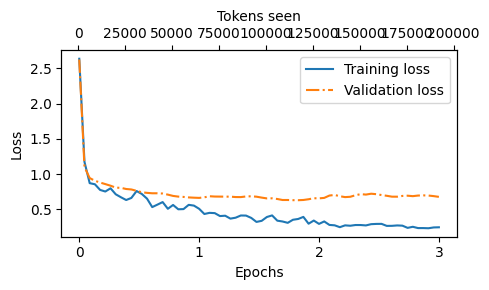

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Sample Model Inference on Instruction Data

This code snippet demonstrates how the instruction-tuned GPT2 model responds to unseen examples from the test set:

- **Input Construction**: Each example is formatted using the `format_input()` function.
- **Generation**: The `generate()` function performs autoregressive decoding up to 256 new tokens.
- **Post-Processing**: The generated output is trimmed after the input, and the `"### Response:"` prefix is removed to extract the model's reply.

#### Example 1
**Instruction**: Rewrite the sentence using a simile.  
**Input**: The car is very fast.  
**Correct Response**: The car is as fast as lightning.  
**Model Response**: The car is as fast as a bullet.


#### Example 2
**Instruction**: What type of cloud is typically associated with thunderstorms?  
**Correct Response**: The type of cloud typically associated with thunderstorms is cumulonimbus.  
**Model Response**: The type of cloud typically associated with thunderstorms is a cumulus (thin, water-filled, or gas-filled) cloud.


#### Example 3
**Instruction**: Name the author of 'Pride and Prejudice'.  
**Correct Response**: Jane Austen.  
**Model Response**: The author of 'Pride and Prejudice' is Jane Austen.

> The model correctly captures intent and structure in most examples, though factual precision may vary slightly depending on the prompt.


In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus (thin, water-filled, or gas-filled) cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Mo

### Generating and Saving Model Responses

This block performs **batch inference** on the test dataset and saves the model’s predictions:

- It loops over each test sample using `tqdm` for a progress bar.
- Each input is formatted and tokenized, then passed into the `generate()` function.
- The model's raw output tokens are decoded and post-processed to extract only the response part.
- The generated response is added to each entry under the key `"model_response"`.
- Finally, all updated test entries are written to a file named `instruction-data-with-response.json` in a readable (pretty-printed) JSON format.

> This step is essential for later evaluation or visual inspection of model performance across unseen instructions.


In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:32<00:00,  1.18it/s]


### Example Entry from the Test Dataset

The following dictionary represents a single data point in the test set, showing both the ground-truth output and the model-generated response:

- **Instruction**: `"Rewrite the sentence using a simile."`
- **Input**: `"The car is very fast."`
- **Expected Output**: `"The car is as fast as lightning."`
- **Model Response**: `"The car is as fast as a bullet."`

> This format is useful for evaluating how closely the model's output aligns with the intended response based on natural language understanding and stylistic accuracy.


In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


### Saving the Fine-Tuned Model

The model’s weights are saved to disk using `torch.save()`, with a filename automatically generated from the model name (`CHOOSE_MODEL`) by removing spaces and parentheses.

- Example saved file: `gpt2-medium355M-sft.pth`

You can later reload the model using:
```python
model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))


In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth
